# Mercari Price Suggestion Challenge
- Task: Build an algorithm that automatically suggests the right product prices. 
- Data: User-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

In [1]:
import numpy as np
import pandas as pd
import pickle
import xgboost
from scipy import sparse
import xgboost
import seaborn as sb
%matplotlib inline

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectPercentile, f_classif


## Data Exploration

In [2]:
train_data = pd.read_table('data/train.tsv')
test_data = pd.read_table('data/test.tsv')

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


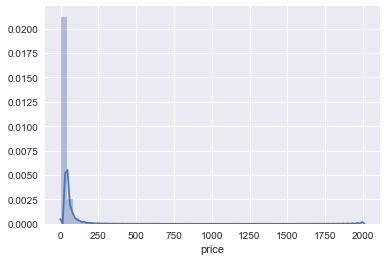

In [3]:
# Check Outliers
print (train_data['price'].describe())
sb.distplot(train_data['price'])

In [4]:
### Check the NaN values
def check_nan(data):
    data_check = data.replace('NaN',np.nan)
    data_check = data.replace('No description yet',np.nan)
    data_nan = data_check.isnull().sum()
    data_nan.sort_values(ascending=False, inplace=True)
    print ('\nTotal number of NaN values in the dataset:',data_nan.sum())
    print ('\nTop three features with most NaN values in the dataset:')
    print (data_nan[:5])
    
check_nan(train_data)
check_nan(test_data)


Total number of NaN values in the dataset: 721502

Top three features with most NaN values in the dataset:
brand_name          632682
item_description     82493
category_name         6327
shipping                 0
price                    0
dtype: int64

Total number of NaN values in the dataset: 337086

Top three features with most NaN values in the dataset:
brand_name           295525
item_description      38503
category_name          3058
shipping                  0
item_condition_id         0
dtype: int64


In [5]:
def get_feature_label(data):
    # remove outliers
    data_after = data[data['price']<400]
    # split features and labels
    train_features = data_after.drop(['price'],axis=1)
    train_labels = data_after.price
    return train_features,train_labels

In [6]:
# change this variable to get raw/sample data
train_features,train_labels=get_feature_label(train_data)
train_features=train_features#[:1000]
train_labels=train_labels#[:1000]
test_features=test_data

In [7]:
train_features.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity


In [8]:
test_features.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


## Feature Engineering

### Categorical data

In [9]:
def category(data):
    cat = data.category_name.str.split('/', expand = True)
    data["main_cat"] = cat[0]
    data["subcat1"] = cat[1]
    data["subcat2"] = cat[2]
    try:
        data["subcat3"] = cat[3]
    except:
        data["subcat3"] = np.nan  
    try:
        data["subcat4"] = cat[4]
    except:
        data["subcat4"] = np.nan  
        
def missing_data(data, _value = 'None'):
    # Handle missing data
    for col in data.columns:
        data[col].fillna(_value,inplace=True)

In [10]:
category(train_features)
category(test_features)

missing_data(train_features)
missing_data(test_features)

In [11]:
## convert categorical var to numeric 
le = preprocessing.LabelEncoder()
def cat_to_num(train,test):
    suf="_le"
    for col in ['brand_name','main_cat','subcat1','subcat2','subcat3','subcat4']:
        train[col+suf] = le.fit_transform(train[col])
        dic = dict(zip(le.classes_, le.transform(le.classes_)))
        test[col+suf] = test[col].map(dic).fillna(0).astype(int) 
        
        print("{} is transformed to {}".format(col,col+suf))

In [12]:
cat_to_num(train_features,test_features)

brand_name is transformed to brand_name_le
main_cat is transformed to main_cat_le
subcat1 is transformed to subcat1_le
subcat2 is transformed to subcat2_le
subcat3 is transformed to subcat3_le
subcat4 is transformed to subcat4_le


In [13]:
## Length of item discription
train_features['Length_of_item_description']=train_features['item_description'].apply(len)
test_features['Length_of_item_description']=test_features['item_description'].apply(len)

In [14]:
## Combine numeric features
def numeric_to_features(data):
    numeric_features = list(data.apply(lambda x:(x['shipping'],x['item_condition_id'],x['main_cat_le'],\
                                                 x['subcat1_le'],x['subcat2_le'],x['subcat3_le'],\
                                                 x['subcat4_le'],x['Length_of_item_description'],\
                                                 x['brand_name_le']), axis=1))
    return numeric_features


In [15]:
train_numeric_features = numeric_to_features(train_features)
test_numeric_features = numeric_to_features(test_features)

### Text Feature

In [16]:
def text_process(data):
    # Process text    
    # make item_description and name lower case    
    text = list(data.apply(lambda x:'%s %s' %(x['item_description'],x['name']), axis=1))
    return text

In [17]:
train_text =text_process(train_features)
test_text =text_process(test_features)

In [18]:
# Tfidf
    # save the vectorize
    # pickle.dump(tfidf,open('vectorizer.pkl', "bw",-1))
    # tfidf=pickle.load(open('vectorizer.pkl','br'))
    
# check if we should use max_features parameter
tfidf = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,3), stop_words = 'english',max_features = 50000)
train_text_features = tfidf.fit_transform(train_text)
test_text_features = tfidf.transform(test_text)

In [19]:
#  Stacker for sparse data
train_final_features = sparse.hstack((train_numeric_features,train_text_features))
test_final_features = sparse.hstack((test_numeric_features,test_text_features))

In [20]:
# save the features
pickle.dump(train_final_features,open('train_features.pkl', "bw"))
pickle.dump(test_final_features,open('test_features.pkl', "bw"))
pickle.dump(train_labels,open('train_labels.pkl', "bw"))

## Pick and Tune the Algorithms

An algorithm may be highly sensitive to some of its features. The choose of good parameters may have a dominant effect on the algorithm performance. 

In this study, we use GridSearchCV to fine tune the algorithm. I start with default parameters and level it up and down. Based on the GridSearchCV function I will adjust the parameters again. For example, if the GridSearchCV chooses the smallest value for the parameter, I will add a smaller number in the search list.

### Load the data

In [2]:
train_final_features = pickle.load(open('train_features.pkl','br'))
test_final_features = pickle.load(open('test_features.pkl','br'))
train_labels = pickle.load(open('train_labels.pkl','br'))

In [ ]:
# xgboost

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, subsample=[0.75], \
                           num_round = 300 , max_depth=7)
xgb = xgb.fit(train_final_features, train_labels)
reg = xgb.best_estimator_

In [3]:
# gridsearchcv
'''
learning_rate ＝ 0.1 or smaller
tree_depth ＝ 2～8；
subsample ＝ 30%～80% of training set；
'''

In [ ]:
pred_label = reg.predict(test_final_features)

### Test

In [ ]:
# vectorized error calc
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [ ]:
# test
from sklearn.model_selection import train_test_split

def test_reg(features, labels):
    features_train, features_test, labels_train, labels_test = train_test_split(\
                features, labels, test_size=0.8, random_state=0)
    ### fit the classifier using training set, and test on test set
    reg.fit(features_train, (labels_train))
    #r_squared = reg.score(features_test, labels_test)
    y_true = labels_test
    y_pred = (reg.predict(features_test))
    y_pred[y_pred<0]=0
    #rms = sqrt(mean_squared_error(y_true, y_pred))
    jag=rmsle(y_true,y_pred)
    print(jag)
    

In [ ]:
test_reg(train_final_features, train_labels)

## Save the results

In [ ]:
outfile_name = 'submit.csv'
pred_label[pred_label<0]=0

pred_label = pd.DataFrame(np.array(pred_label), columns = ['price'])
pred_label.index.name = 'test_id'
pred_label.to_csv(outfile_name, encoding='utf-8')